# Image_Scaner_CNN

## 导包

In [1]:
import urllib
from urllib.request import urlretrieve
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import pickle
from PIL import Image
import PIL.ImageOps
import os
from os.path import isfile, isdir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 获取下载文件保存路径

In [2]:
def get_file_full_name(folder_path, name):
    return folder_path + name

## 下载文件到指定文件夹

In [3]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
def download_files(folder_path, image_names):
    if not isdir(folder_path):
        os.mkdir(folder_path)
    for image_name in image_names:
        if not isfile(get_file_full_name(folder_path, image_name)):
            # 谷歌云存储公共下载链接
            url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + image_name + '.npy'
            # base64 转换之空格版
            url = url.replace(' ', '%20')
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc=image_name) as pbar:
                urlretrieve(
                url,
                folder_path + image_name,
                pbar.hook)

## 获取最大的文件大小

In [4]:
def get_max_images_size(folder_path, image_names):
    image_num_list = []
    for image_name in image_names:
        images = np.load(get_file_full_name(folder_path, image_name))
        image_num_list.append(len(images))
    return max(image_num_list)

## 获取数组乱序列表（numpy）

In [5]:
def get_shuffle(data):
    records = len(data)
    shuffle = np.arange(records)
    np.random.shuffle(shuffle)
    return shuffle

## 序列化数据到指定路径

In [6]:
def preprocess_and_save_data(folder_path, features, labels):
    pickle.dump((features, labels), open(folder_path, 'wb'))
#     train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.1)
#     pickle.dump((train_features, train_labels), open(folder_path + '/train', 'wb'))
#     pickle.dump((valid_features, valid_labels), open(folder_path + '/valid', 'wb'))

## 标准化

In [7]:
def normalize(x):
    return x / 255

## One-hot 编码

In [8]:
def word2index(image_names):
    result = {}
    for index, name in enumerate(image_names):
        result[name] = index
    return result
def one_hot_encode_lb(x):
    lb = preprocessing.LabelBinarizer()
    lb.fit(range(len(x)))
    return lb

## 开始下载

In [9]:
image_name_file = 'mini_quick_draw.txt'
batch_num = 0
batch_max = 700
batch_size = 100

In [10]:
image_names = []
with open(image_name_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if lines:
            image_names.append(line.replace('\n',''))

folder_path = 'npys/'
download_files(folder_path, image_names)

star: 108MB [00:01, 55.7MB/s]                              
square: 98.1MB [00:01, 73.6MB/s]                              
face: 127MB [00:01, 68.6MB/s]                              
moon: 95.4MB [00:01, 72.4MB/s]                            
butterfly: 92.5MB [00:01, 80.0MB/s]                            
cell phone: 95.0MB [00:01, 69.5MB/s]                            
cup: 102MB [00:01, 70.0MB/s]                              
pants: 113MB [00:01, 76.8MB/s]                              
clock: 94.5MB [00:01, 72.1MB/s]                            
triangle: 96.6MB [00:01, 76.9MB/s]                            
basketball: 105MB [00:01, 78.1MB/s]                              
lollipop: 101MB [00:01, 69.8MB/s]                            
rainbow: 99.5MB [00:01, 78.2MB/s]                              
fish: 105MB [00:01, 53.2MB/s]                              
fork: 98.8MB [00:01, 76.1MB/s]                            


## 显示下载数据（可选）

In [11]:
image_name = 'face'
images = np.load(folder_path + image_name)
PIL.ImageOps.invert(Image.fromarray(images[0].reshape(28,28)).resize((28,28),Image.ANTIALIAS).convert('L'))

## 数据预处理

In [ ]:
max_images_size = get_max_images_size(folder_path, image_names)
w2i = word2index(image_names)
lb = one_hot_encode_lb(image_names)

if not isdir('data'):
        os.mkdir('data')

for start in range(0, max_images_size, batch_size):
    if batch_num > batch_max:
        break
    features = []
    labels = []
    for image_name in image_names:
        images = np.load(folder_path + image_name)
        end = min(start + batch_size, len(images))
        if start < end:
            for feature in images[start:end]:
                feature = Image.fromarray(feature.reshape(28,28))
                feature = feature.resize((28,28),Image.ANTIALIAS)
                feature = feature.convert('L')
                feature = np.array(feature).astype(np.float32)
                features.append(feature.reshape(28, 28, 1))
                labels.append(w2i[image_name])
    if labels:
        shuffle = get_shuffle(labels)
        features = np.array(features)
        labels = np.array(labels)
        
        # 打乱
        features = features[shuffle]
        labels = labels[shuffle]
        
        features = normalize(features)
        labels = lb.transform(labels)
        # 保存
        preprocess_and_save_data('data/batch' + str(batch_num), features, labels)
        batch_num += 1

## 测试数据预处理是否正确

<class 'numpy.ndarray'>
1500 条
(1500, 15)
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


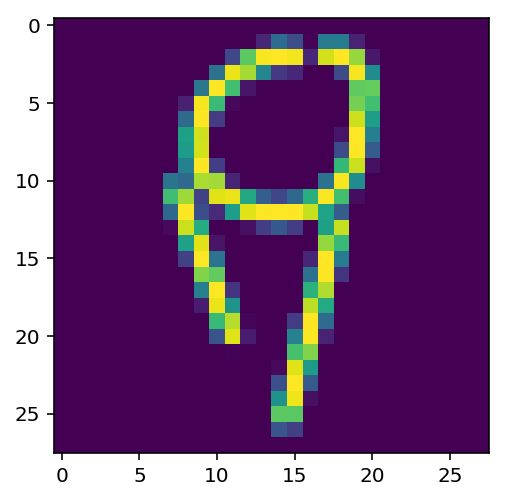

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

index = 0
train_features, train_labels = pickle.load(open('data/batch0', mode='rb'))
print(type(train_features))
print('%d 条' % len(train_features))
print(train_labels.shape)
print(train_labels[index])

image = Image.fromarray(train_features[index].reshape(28,28)*255)
image = image.convert('L')
plt.imshow(image)

# --------------------------------------------------------------------------------------------

## 检查点

In [15]:
valid_features, valid_labels = pickle.load(open('data/batch0', mode='rb'))

# 搭建 CNN

In [16]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name='x')

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, (None, n_classes), name='y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    weight = tf.Variable(tf.truncated_normal((list(conv_ksize) + [x_tensor.get_shape().as_list()[3], conv_num_outputs]), stddev=0.04))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    # 2D Convolution Layer
    output = tf.nn.conv2d(x_tensor,
                          weight,
                          [1, conv_strides[0], conv_strides[1], 1],
                          padding='SAME')
    output = tf.nn.bias_add(output, bias)
    # Pooling Layer
    output = tf.nn.max_pool(output,
                          [1, pool_ksize[0], pool_ksize[1], 1],
                          [1, pool_strides[0], pool_strides[1], 1],
                          padding='SAME')
    return output

def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, shape[1]*shape[2]*shape[3]])


def fully_conn(x_tensor, num_outputs):
    weight = tf.Variable(tf.truncated_normal((x_tensor.get_shape().as_list()[1], num_outputs), stddev=0.04))
    bias = tf.Variable(tf.zeros(num_outputs))
    output = tf.add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(output)

def output(x_tensor, num_outputs):
    weight = tf.Variable(tf.truncated_normal((x_tensor.get_shape().as_list()[1], num_outputs), stddev=0.04))
    bias = tf.Variable(tf.zeros(num_outputs))
    output = tf.add(tf.matmul(x_tensor, weight) , bias)
    return output

In [34]:
##############################
## Build the Neural Network ##
##############################

def conv_net(x, keep_prob):
    conv = conv2d_maxpool(x,
                           conv_num_outputs=64,
                           conv_ksize=[3,3],
                           conv_strides=[1,1],
                           pool_ksize=[2,2],
                           pool_strides=[2,2])
    
    conv = conv2d_maxpool(conv,
                          conv_num_outputs=128,
                          conv_ksize=[3,3],
                          conv_strides=[1,1],
                          pool_ksize=[2,2],
                          pool_strides=[2,2])
    
    conv = conv2d_maxpool(conv,
                          conv_num_outputs=256,
                          conv_ksize=[3,3],
                          conv_strides=[1,1],
                          pool_ksize=[2,2],
                          pool_strides=[2,2])
    
    conv = conv2d_maxpool(conv,
                          conv_num_outputs=512,
                          conv_ksize=[3,3],
                          conv_strides=[1,1],
                          pool_ksize=[2,2],
                          pool_strides=[2,2])
    
    conv = conv2d_maxpool(conv,
                          conv_num_outputs=1024,
                          conv_ksize=[3,3],
                          conv_strides=[1,1],
                          pool_ksize=[2,2],
                          pool_strides=[2,2])

    flt = flatten(conv)

    fc = fully_conn(flt, 512)
    fc = fully_conn(fc, 512)
    fc = fully_conn(fc, 1024)
    fc = tf.nn.dropout(fc, keep_prob)
    
    o = output(fc, len(image_names))
    return o

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((28, 28, 1))
y = neural_net_label_input(len(image_names))
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [35]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x:feature_batch,
                                      y:label_batch,
                                      keep_prob:keep_probability})

In [36]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features,
                                              y: valid_labels,
                                              keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    return valid_acc

## 超参数

In [37]:
# TODO: Tune Parameters
epochs = 1
keep_probability = 0.75
break_percent = 0.98

## 开始训练模型

In [38]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = batch_max
        for batch_i in range(1, n_batches):
            batch_features, batch_labels = pickle.load(open('data/batch' + str(batch_i), mode='rb'))
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            if(print_stats(sess, batch_features, batch_labels, cost, accuracy) > break_percent):
                break
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     0.4967 Validation Accuracy: 0.077333
Epoch  1, CIFAR-10 Batch 2:  Loss:     0.3448 Validation Accuracy: 0.066000
Epoch  1, CIFAR-10 Batch 3:  Loss:     0.2644 Validation Accuracy: 0.066667
Epoch  1, CIFAR-10 Batch 4:  Loss:     0.2898 Validation Accuracy: 0.066667
Epoch  1, CIFAR-10 Batch 5:  Loss:     0.2693 Validation Accuracy: 0.066667
Epoch  1, CIFAR-10 Batch 6:  Loss:     0.2588 Validation Accuracy: 0.069333
Epoch  1, CIFAR-10 Batch 7:  Loss:     0.2744 Validation Accuracy: 0.092000
Epoch  1, CIFAR-10 Batch 8:  Loss:     0.2488 Validation Accuracy: 0.066667
Epoch  1, CIFAR-10 Batch 9:  Loss:     0.2565 Validation Accuracy: 0.116667
Epoch  1, CIFAR-10 Batch 10:  Loss:     0.2579 Validation Accuracy: 0.067333
Epoch  1, CIFAR-10 Batch 11:  Loss:     0.2443 Validation Accuracy: 0.068000
Epoch  1, CIFAR-10 Batch 12:  Loss:     0.2517 Validation Accuracy: 0.068000
Epoch  1, CIFAR-10 Batch 13:  Loss:     0.2497 Validation Accuracy: 0.074

Epoch  1, CIFAR-10 Batch 107:  Loss:     0.0396 Validation Accuracy: 0.912000
Epoch  1, CIFAR-10 Batch 108:  Loss:     0.0364 Validation Accuracy: 0.908667
Epoch  1, CIFAR-10 Batch 109:  Loss:     0.0373 Validation Accuracy: 0.908000
Epoch  1, CIFAR-10 Batch 110:  Loss:     0.0392 Validation Accuracy: 0.913333
Epoch  1, CIFAR-10 Batch 111:  Loss:     0.0357 Validation Accuracy: 0.907333
Epoch  1, CIFAR-10 Batch 112:  Loss:     0.0371 Validation Accuracy: 0.910000
Epoch  1, CIFAR-10 Batch 113:  Loss:     0.0358 Validation Accuracy: 0.906000
Epoch  1, CIFAR-10 Batch 114:  Loss:     0.0345 Validation Accuracy: 0.908667
Epoch  1, CIFAR-10 Batch 115:  Loss:     0.0349 Validation Accuracy: 0.913333
Epoch  1, CIFAR-10 Batch 116:  Loss:     0.0368 Validation Accuracy: 0.909333
Epoch  1, CIFAR-10 Batch 117:  Loss:     0.0356 Validation Accuracy: 0.918667
Epoch  1, CIFAR-10 Batch 118:  Loss:     0.0329 Validation Accuracy: 0.921333
Epoch  1, CIFAR-10 Batch 119:  Loss:     0.0342 Validation Accur

Epoch  1, CIFAR-10 Batch 212:  Loss:     0.0258 Validation Accuracy: 0.936000
Epoch  1, CIFAR-10 Batch 213:  Loss:     0.0247 Validation Accuracy: 0.942000
Epoch  1, CIFAR-10 Batch 214:  Loss:     0.0220 Validation Accuracy: 0.934000
Epoch  1, CIFAR-10 Batch 215:  Loss:     0.0221 Validation Accuracy: 0.938667
Epoch  1, CIFAR-10 Batch 216:  Loss:     0.0233 Validation Accuracy: 0.939333
Epoch  1, CIFAR-10 Batch 217:  Loss:     0.0252 Validation Accuracy: 0.941333
Epoch  1, CIFAR-10 Batch 218:  Loss:     0.0239 Validation Accuracy: 0.939333
Epoch  1, CIFAR-10 Batch 219:  Loss:     0.0274 Validation Accuracy: 0.938000
Epoch  1, CIFAR-10 Batch 220:  Loss:     0.0242 Validation Accuracy: 0.942000
Epoch  1, CIFAR-10 Batch 221:  Loss:     0.0171 Validation Accuracy: 0.942667
Epoch  1, CIFAR-10 Batch 222:  Loss:     0.0259 Validation Accuracy: 0.939333
Epoch  1, CIFAR-10 Batch 223:  Loss:     0.0265 Validation Accuracy: 0.946667
Epoch  1, CIFAR-10 Batch 224:  Loss:     0.0226 Validation Accur

Epoch  1, CIFAR-10 Batch 317:  Loss:     0.0210 Validation Accuracy: 0.952667
Epoch  1, CIFAR-10 Batch 318:  Loss:     0.0186 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 319:  Loss:     0.0266 Validation Accuracy: 0.954000
Epoch  1, CIFAR-10 Batch 320:  Loss:     0.0223 Validation Accuracy: 0.953333
Epoch  1, CIFAR-10 Batch 321:  Loss:     0.0248 Validation Accuracy: 0.956000
Epoch  1, CIFAR-10 Batch 322:  Loss:     0.0198 Validation Accuracy: 0.950000
Epoch  1, CIFAR-10 Batch 323:  Loss:     0.0225 Validation Accuracy: 0.950667
Epoch  1, CIFAR-10 Batch 324:  Loss:     0.0238 Validation Accuracy: 0.955333
Epoch  1, CIFAR-10 Batch 325:  Loss:     0.0179 Validation Accuracy: 0.956667
Epoch  1, CIFAR-10 Batch 326:  Loss:     0.0204 Validation Accuracy: 0.958667
Epoch  1, CIFAR-10 Batch 327:  Loss:     0.0173 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 328:  Loss:     0.0215 Validation Accuracy: 0.956000
Epoch  1, CIFAR-10 Batch 329:  Loss:     0.0214 Validation Accur

Epoch  1, CIFAR-10 Batch 422:  Loss:     0.0190 Validation Accuracy: 0.960000
Epoch  1, CIFAR-10 Batch 423:  Loss:     0.0194 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 424:  Loss:     0.0177 Validation Accuracy: 0.954000
Epoch  1, CIFAR-10 Batch 425:  Loss:     0.0166 Validation Accuracy: 0.950000
Epoch  1, CIFAR-10 Batch 426:  Loss:     0.0168 Validation Accuracy: 0.954667
Epoch  1, CIFAR-10 Batch 427:  Loss:     0.0195 Validation Accuracy: 0.958667
Epoch  1, CIFAR-10 Batch 428:  Loss:     0.0165 Validation Accuracy: 0.956000
Epoch  1, CIFAR-10 Batch 429:  Loss:     0.0180 Validation Accuracy: 0.962667
Epoch  1, CIFAR-10 Batch 430:  Loss:     0.0188 Validation Accuracy: 0.959333
Epoch  1, CIFAR-10 Batch 431:  Loss:     0.0188 Validation Accuracy: 0.958667
Epoch  1, CIFAR-10 Batch 432:  Loss:     0.0199 Validation Accuracy: 0.956667
Epoch  1, CIFAR-10 Batch 433:  Loss:     0.0181 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 434:  Loss:     0.0145 Validation Accur

Epoch  1, CIFAR-10 Batch 527:  Loss:     0.0154 Validation Accuracy: 0.959333
Epoch  1, CIFAR-10 Batch 528:  Loss:     0.0148 Validation Accuracy: 0.960667
Epoch  1, CIFAR-10 Batch 529:  Loss:     0.0179 Validation Accuracy: 0.963333
Epoch  1, CIFAR-10 Batch 530:  Loss:     0.0180 Validation Accuracy: 0.962667
Epoch  1, CIFAR-10 Batch 531:  Loss:     0.0151 Validation Accuracy: 0.960667
Epoch  1, CIFAR-10 Batch 532:  Loss:     0.0150 Validation Accuracy: 0.962667
Epoch  1, CIFAR-10 Batch 533:  Loss:     0.0144 Validation Accuracy: 0.967333
Epoch  1, CIFAR-10 Batch 534:  Loss:     0.0148 Validation Accuracy: 0.966000
Epoch  1, CIFAR-10 Batch 535:  Loss:     0.0170 Validation Accuracy: 0.960000
Epoch  1, CIFAR-10 Batch 536:  Loss:     0.0174 Validation Accuracy: 0.962667
Epoch  1, CIFAR-10 Batch 537:  Loss:     0.0124 Validation Accuracy: 0.962667
Epoch  1, CIFAR-10 Batch 538:  Loss:     0.0167 Validation Accuracy: 0.967333
Epoch  1, CIFAR-10 Batch 539:  Loss:     0.0136 Validation Accur

Epoch  1, CIFAR-10 Batch 632:  Loss:     0.0146 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 633:  Loss:     0.0141 Validation Accuracy: 0.952667
Epoch  1, CIFAR-10 Batch 634:  Loss:     0.0128 Validation Accuracy: 0.959333
Epoch  1, CIFAR-10 Batch 635:  Loss:     0.0190 Validation Accuracy: 0.963333
Epoch  1, CIFAR-10 Batch 636:  Loss:     0.0146 Validation Accuracy: 0.962000
Epoch  1, CIFAR-10 Batch 637:  Loss:     0.0171 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 638:  Loss:     0.0166 Validation Accuracy: 0.963333
Epoch  1, CIFAR-10 Batch 639:  Loss:     0.0182 Validation Accuracy: 0.958000
Epoch  1, CIFAR-10 Batch 640:  Loss:     0.0181 Validation Accuracy: 0.952667
Epoch  1, CIFAR-10 Batch 641:  Loss:     0.0177 Validation Accuracy: 0.955333
Epoch  1, CIFAR-10 Batch 642:  Loss:     0.0152 Validation Accuracy: 0.948000
Epoch  1, CIFAR-10 Batch 643:  Loss:     0.0180 Validation Accuracy: 0.952000
Epoch  1, CIFAR-10 Batch 644:  Loss:     0.0155 Validation Accur